In [294]:
import pandas as pd
import numpy as np
import re
import requests
import time

from bs4 import BeautifulSoup

def moveSibling(tag, number):
	i = 1
	while i <= number:
		tag = tag.nextSibling
		i += 1
	return tag

from matplotlib import pyplot
%matplotlib inline

In [2]:
columns_dl = 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A'
downloaded_df = pd.DataFrame(data=None, columns=columns_dl)

In [3]:
for year in range(2006, 2017):
    y1 = str(year)[2:]
    y2 = str(year+1)[2:]
    url = "http://www.football-data.co.uk/mmz4281/" + y1 + y2 + "/D1.csv"
    df = pd.read_csv(url)
    df = df.loc[:, columns_dl]
    downloaded_df = downloaded_df.append(df)

In [4]:
seasonlist = [2006 + (i+1)/(9*34) for i in range(len(downloaded_df))]
gamedaylist = [1 + np.mod(i/9,34) for i in range(len(downloaded_df))]

In [5]:
downloaded_df.loc[:, "Season"] = seasonlist
downloaded_df.loc[:, "Gameday"] = gamedaylist

In [6]:
teamlist = downloaded_df.loc[:, "HomeTeam"].unique()
data = np.array([range(len(teamlist)), teamlist]).T
team_df = pd.DataFrame(data=data, columns=['TID', 'team'])

In [7]:
cleaned_df = pd.merge(team_df, downloaded_df, how='inner', left_on='team', right_on='HomeTeam')
cleaned_df = pd.merge(team_df, cleaned_df, how='inner', left_on='team', right_on='AwayTeam', suffixes=('_A', '_H'))

columns_cl = ['Season', 'Gameday', 'TID_H', 'TID_A', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
cleaned_df = cleaned_df.loc[:, columns_cl].sort_values(['Season', 'Gameday'])
cleaned_df.index = range(len(cleaned_df))

cleaned_df.to_csv('Bundesliga_Data_2006_2016.csv', index=False)
team_df = team_df.set_index('TID')

In [16]:
try:
    kicker_grades_df = pd.read_csv('Grades_2005_2016.csv')
except:
    if input('Re-download? yes?') == 'yes':
        grade_row = []
        for year in range(2005, 2017):
            for gameday in range(1,35):
                print year, gameday
                url = "http://www.kicker.de/news/fussball/bundesliga/spieltag/1-bundesliga/"
                url = url + str(year) + "-" + str(year+1)[2:4] + "/"
                url = url + str(gameday) + "/0/spieltag.html"

                website = requests.get(url)
                main = BeautifulSoup(website.content, 'html.parser')
                main_table = main.find('table', {'class': 'tStat', 'summary': 'Tabelle'})

                # Once we get to the unplayed gamedays, no table will be displayed, and the loop shall end.
                try:
                    main_standings = main_table.find_all('a', {'class': 'link verinsLinkBild'})
                except:
                    break

                # If we didn't break, proceed as usual.

                main_matches = main.find('table', {'class': 'tStat tab1-bundesliga', 'summary': 'Begegnungen'})

                # Find all links of class "link." These refer to the game analyses.
                for game in main_matches.find_all('a', {'class' : 'link'}):
                    # result = game.parent.previous_sibling.previous_sibling.text
                    # result = map(int, result[0:result.find("(")-1].split(":"))

                    game_url = game.get('href')
                    encoded_in_url = game_url.split("/")

                    # Game ID is the article ID for kicker, as unique ID for game
                    game_id = encoded_in_url[8][0:7]

                    # Game URL encodes the teams which are playing
                    teams = encoded_in_url[9][13:-5].split("_")
                    teams = map(int, [teams[i][teams[i].rfind('-')+1:] for i in range(2)])

                    # URL to open individiual games
                    game_url = "http://www.kicker.de" + game_url
                    error_count = 0
                    while error_count < 10:
                        try:
                            game_file = requests.get(game_url)
                            game_soup = BeautifulSoup(game_file.content, 'html.parser')
                            game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'}).find_all('div', {'class': 'aufstellung_team'})
                            break
                        except:
                            error_count += 1

                    if error_count == 10:
                        continue

                    i = 0
                    for lineup in game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'}).find_all('div', {'class': 'aufstellung_team'}):
                        no_players = 0
                        grade = 0.
                        for player in lineup.find_all('a'):
                            grade_raw = unicode(player.next_sibling)

                            grade_del1 = unicode(grade_raw).find('(')
                            grade_del2 = unicode(grade_raw).find(')')

                            if grade_del1 == -1:
                                continue

                            grade += float(grade_raw[grade_del1+1:grade_del2].replace(",", "."))

                            no_players += 1
                            if no_players == 11:
                                break
                        grade = grade/no_players

                        grade_row += [[year, gameday, teams[np.mod(i,2)], grade]]
                        i += 1
    else:
        "Doing nothing. No df loaded."

try:
    kicker_grades_df = kicker_grades_df.drop('Unnamed: 0', axis=1)
except:
    print "Import Successful"

kicker_grades_df.head()

Import Successful


,Season,Gameday,KID,GradeAvg
0,2005,1,14,3.136364
1,2005,1,15,4.045455
2,2005,1,16,3.636364
3,2005,1,30,3.863636
4,2005,1,1,3.181818


In [17]:
kicker_grades_df.to_csv('Grades_2005_2016.csv', index=False)

In [64]:
team_list = []
for year in range(2005,2017):
    url = 'http://www.kicker.de/news/fussball/bundesliga/vereine/1-bundesliga/'
    url += str(year) + '-' + str(year+1)[-2:]
    url += '/vereine-liste.html'

    website = requests.get(url)
    main = BeautifulSoup(website.content, 'html.parser')
    for team in main.find_all('a', {'class': 'link verinsLinkBild'}):
        team_name_id = team.get('href').split('/')[7]
        team_name = team_name_id[0:team_name_id.rfind("-")]
        team_id = team_name_id[team_name_id.rfind("-")+1:]
        team_list += [[int(team_id), team_name]]
    

In [73]:
kicker_team_df = pd.DataFrame(data=team_list, columns=['KID', 'KName'])
kicker_team_df = kicker_team_df.drop_duplicates().set_index('KID')

In [18]:
key_df = pd.read_csv('Team_ID_hardcoded.csv')
key_df.head()

,TID,KID,TName
0,0,14,Bayern Munich
1,1,12,Hamburg
2,2,9,Leverkusen
3,3,30,Mainz
4,4,15,M'gladbach


In [282]:
def rescale_grade(x):
    return 1 - (x-1.)/5

grades_df = kicker_grades_df.merge(key_df, how='left', left_on='KID', right_on='KID').loc[:, ('Season', 'Gameday','TID', 'GradeAvg')]
grades_df = grades_df.set_index(['TID', 'Season', 'Gameday']).sort_index()
grades_df = grades_df.apply(rescale_grade)

print grades_df.loc[:, 'GradeAvg'].min()
print grades_df.loc[:, 'GradeAvg'].max()

0.027272727272
0.845454545454


In [381]:
def inverse(x):
    return 1./x
def points(x):
    if x > 0:
        return 1
    elif x == 0:
        return 1./3
    else:
        return 0

In [380]:
complete_df = cleaned_df.merge(grades_df, how='inner', left_on=['TID_H', 'Season', 'Gameday'], right_index=True)
complete_df = complete_df.merge(grades_df, how='inner', left_on=['TID_A', 'Season', 'Gameday'], right_index=True)

complete_df = complete_df.rename(columns={'GradeAvg_x': 'HGA', 'GradeAvg_y': 'AGA'})
complete_df = complete_df.replace({'H':1, 'D':0.5, 'A':0})
complete_df.loc[:, 'FTGD'] = complete_df.loc[:, 'FTHG'] - complete_df.loc[:, 'FTAG']
complete_df.loc[:, 'HTGD'] = complete_df.loc[:, 'HTHG'] - complete_df.loc[:, 'HTAG']

complete_df.loc[:, 'Odds'] = (complete_df.filter(regex='^B365').apply(inverse)*(1,0.5,0)).apply(np.sum, axis=1)

complete_df.head()

,Season,Gameday,TID_H,TID_A,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HR,AR,B365H,B365D,B365A,HGA,AGA,FTGD,HTGD,Odds
0,2006,1,6,9,0.0,3.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.00,3.2,3.75,0.309091,0.727273,-3.0,-2.0,0.656250
1,2006,1,2,10,3.0,0.0,1.0,2.0,0.0,1.0,...,1.0,1.0,1.44,4.0,7.50,0.654545,0.300000,3.0,2.0,0.819444
2,2006,1,4,11,2.0,0.0,1.0,0.0,0.0,0.5,...,0.0,1.0,1.61,3.6,5.50,0.545455,0.427273,2.0,0.0,0.760007
3,2006,1,0,12,2.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.57,3.6,6.00,0.654545,0.381818,2.0,1.0,0.775832
4,2006,1,5,13,1.0,1.0,0.5,1.0,0.0,1.0,...,0.0,0.0,1.44,4.0,7.50,0.581818,0.363636,0.0,1.0,0.819444


In [390]:
complete_df.loc[:, 'Odds'].max()

0.97672955974842757

In [397]:
multi_index = pd.MultiIndex(levels=[[],[],[]],
                             labels=[[],[],[]],
                             names=[u'TID', u'Season', u'Gameday'])
running_df = pd.DataFrame(data=None, columns=['Points'], index=multi_index)

for tid in range(len(key_df)):
    query = 'TID_H == ' + str(tid)
    temp_H = complete_df.query(query).loc[:, ['TID_H', 'Season', 'Gameday', 'FTHG', 'FTAG']]
    temp_H.loc[:, 'Gameday'] += 1
    temp_H.loc[:, 'GD'] = temp_H.loc[:, 'FTHG'] - temp_H.loc[:, 'FTAG']
    temp_H = temp_H.set_index(['TID_H', 'Season', 'Gameday'])

    query = 'TID_A == ' + str(tid)
    temp_A = complete_df.query(query).loc[:, ['TID_A', 'Season', 'Gameday', 'FTHG', 'FTAG']]
    temp_A.loc[:, 'Gameday'] += 1
    temp_A.loc[:, 'GD'] = - temp_A.loc[:, 'FTHG'] + temp_A.loc[:, 'FTAG']
    temp_A = temp_A.set_index(['TID_A', 'Season', 'Gameday'])

    temp = pd.concat([temp_H, temp_A]).sort_index()
    temp.index = temp.index.rename(['TID', 'Season', 'Gameday'])
    temp = temp.loc[:, 'GD'].apply(points).rename('Points').to_frame()
    
    running_df = running_df.append(temp.groupby(level=['TID', 'Season'], group_keys=False).rolling(3, 1).mean())


    

In [398]:
running_df.to_csv('Running_Points_2006_2013.csv')
len(running_df)/2

3174

In [404]:
complete_running_df = complete_df.merge(running_df, how='left', left_on=['TID_H', 'Season', 'Gameday'], right_index=True)
complete_running_df = complete_running_df.merge(running_df, how='left', left_on=['TID_A', 'Season', 'Gameday'], right_index=True)

complete_running_df = complete_running_df.rename(columns={'Points_x': 'HP3', 'Points_y': 'AP3'}).filter(regex='^(?!B365)')
complete_running_df = complete_running_df.drop(['FTAG', 'FTR','HTAG', 'HTR'], axis=1)

complete_running_df = complete_running_df.drop_duplicates(['Season', 'Gameday', 'TID_H', 'TID_A']).fillna(0.5)

In [405]:
complete_running_df.to_csv('All_Data_2006_2016.csv')
len(complete_running_df)

3174

In [403]:
complete_running_df.fillna(0.5)

,Season,Gameday,TID_H,TID_A,FTHG,HTHG,HS,AS,HST,AST,...,AY,HR,AR,HGA,AGA,FTGD,HTGD,Odds,HP3,AP3
0,2006,1,6,9,0.0,0.0,10.0,11.0,8.0,8.0,...,2.0,0.0,0.0,0.309091,0.727273,-3.0,-2.0,0.656250,0.500000,0.500000
1,2006,1,2,10,3.0,2.0,20.0,8.0,11.0,5.0,...,0.0,1.0,1.0,0.654545,0.300000,3.0,2.0,0.819444,0.500000,0.500000
2,2006,1,4,11,2.0,0.0,13.0,11.0,8.0,7.0,...,4.0,0.0,1.0,0.545455,0.427273,2.0,0.0,0.760007,0.500000,0.500000
3,2006,1,0,12,2.0,1.0,12.0,16.0,9.0,7.0,...,2.0,0.0,0.0,0.654545,0.381818,2.0,1.0,0.775832,0.500000,0.500000
4,2006,1,5,13,1.0,1.0,24.0,8.0,13.0,5.0,...,2.0,0.0,0.0,0.581818,0.363636,0.0,1.0,0.819444,0.500000,0.500000
5,2006,1,8,14,0.0,0.0,26.0,10.0,15.0,4.0,...,1.0,0.0,0.0,0.490909,0.418182,0.0,0.0,0.610795,0.500000,0.500000
6,2006,1,7,15,2.0,1.0,14.0,15.0,6.0,8.0,...,3.0,0.0,0.0,0.472727,0.536364,-2.0,0.0,0.403846,0.500000,0.500000
7,2006,1,1,16,1.0,0.0,26.0,10.0,19.0,5.0,...,2.0,0.0,0.0,0.363636,0.490909,0.0,-1.0,0.819444,0.500000,0.500000
8,2006,1,3,17,2.0,1.0,11.0,19.0,5.0,9.0,...,3.0,0.0,0.0,0.527273,0.381818,1.0,1.0,0.656250,0.500000,0.500000
9,2006,2,17,0,1.0,0.0,6.0,21.0,4.0,13.0,...,2.0,0.0,0.0,0.445455,0.509091,-1.0,-1.0,0.313397,0.000000,1.000000


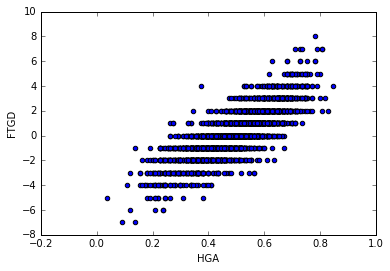

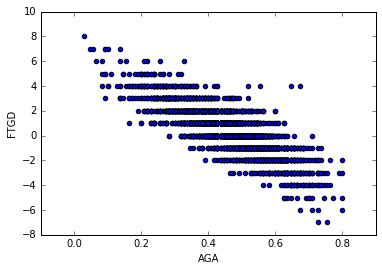

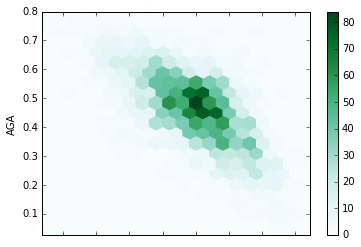

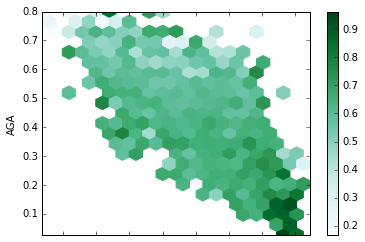

In [401]:
complete_df.plot(kind='scatter', x='HGA', y='FTGD')
complete_df.plot(kind='scatter', x='AGA', y='FTGD')
complete_running_df.plot.hexbin(x='HGA', y='AGA', gridsize=20)
complete_running_df.plot.hexbin(x='HGA', y='AGA', C='Odds', gridsize=20)

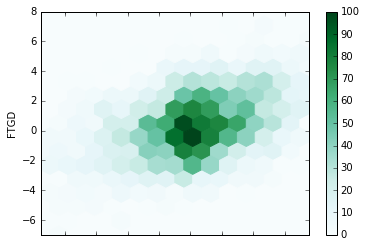

In [410]:
complete_df.plot.hexbin(x='Odds', y='FTGD', gridsize=15)